In [1]:
import qiskit as qk
import numpy as np
from qiskit.tools.visualization import plot_histogram
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.aer.noise import NoiseModel
import matplotlib
import matplotlib.pyplot as plt
from qiskit.visualization import plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
%matplotlib inline
from IPython.display import display

In [2]:
import warnings
warnings.filterwarnings('ignore')
from qiskit.tools.jupyter import *

In [3]:
token = 'b6464d13b284902ed1d1a48d2aed6bd0474c7be45011741b0fb879614419659cb722e74a046af3d5caae0398aec9bdac8843068ecbee91aff466cf3e30f3bef5'
try:
    IBMQ.load_account()
except:
    qk.IBMQ.save_account(token=token)
    qk.IBMQ.enable_account(token)
provider = IBMQ.get_provider(hub="ibm-q", group="open", project="main")
backend = provider.get_backend("ibmq_armonk")

In [4]:
backend_config = backend.configuration()
assert backend_config.open_pulse, "Backend doesn't support Pulse"

In [5]:
dt = backend_config.dt
print(f"Sampling time: {dt*1e9} ns") 
backend_defaults = backend.defaults()
print(backend_defaults)

Sampling time: 0.2222222222222222 ns
<PulseDefaults(<InstructionScheduleMap(1Q instructions:
  q0: {'x', 'sx', 'id', 'measure', 'u3', 'u1', 'u2', 'rz'}
Multi qubit instructions:
)>Qubit Frequencies [GHz]
[4.971677744378156]
Measurement Frequencies [GHz]
[6.993370669] )>


# Setteing up Frequency Sweep

We will first condunct Frequency sweep over a large range to identify our transiton energies

# Initial Frequency 0->1

In [6]:
import numpy as np

# unit conversion factors -> all backend properties returned in SI (Hz, sec, etc.)
GHz = 1.0e9 # Gigahertz
MHz = 1.0e6 # Megahertz
us = 1.0e-6 # Microseconds
ns = 1.0e-9 # Nanoseconds

# We will find the qubit frequency for the following qubit.
qubit = 0
# We will define memory slot channel 0.
mem_slot = 0

# The sweep will be centered around the estimated qubit frequency.
center_frequency_Hz = backend_defaults.qubit_freq_est[qubit]        # The default frequency is given in Hz
                                                                    # warning: this will change in a future release
print(f"Qubit {qubit} has an estimated frequency of {center_frequency_Hz / GHz} GHz.")

# scale factor to remove factors of 10 from the data
scale_factor = 1e-15

# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 20 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz
a=0
# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = center_frequency_Hz - frequency_span_Hz / 2
frequency_max = center_frequency_Hz + frequency_span_Hz / 2
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange((frequency_min / GHz)-a, 
                            (frequency_max / GHz)+a, 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")
print(len(frequencies_GHz))

Qubit 0 has an estimated frequency of 4.971677744378156 GHz.
The sweep will go from 4.9616777443781555 GHz to 4.981677744378156 GHz in steps of 1.0 MHz.
21


We will create a pulse schedule by defining this frequency as a parameter using the parameter class.
First, we will set the required values duration, sigma, and channel.

Then we will set the pulse flow so that the specified pulses are executed sequentially.
We will define the pulse frequency, the pulse used in the experiment, and the measurement pulse.
Here, the pulse used in the experiment specifies the drive pulse, which is a Gaussian pulse.

At each frequency, we will send a drive pulse of that frequency to the qubit and measure immediately after the pulse. 

In [7]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return int(num + 8 ) - (int(num + 8 ) % 16)

In [8]:
# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of_16(sec/dt)

In [9]:
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.


# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.015 * us *4                         # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8                # This is a truncating parameter, because gaussians don't have 
                                                        # a natural finite length
drive_amp = 0.5

frequencies_Hz = frequencies_GHz*GHz
# Create the base schedule
# Start with drive pulse acting on the drive channel
freq = Parameter('freq')
#time = Parameter('time')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(freq, drive_chan)
    # Drive pulse samples
    print(drive_sigma)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              sigma=drive_sigma,
                              amp=drive_amp,
                              name='freq_sweep_excitation_pulse'), drive_chan)
    # Define our measurement pulse
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])
        

# Create the frequency settings for the sweep (MUST BE IN HZ)

times= [1,2,3,4,5]
schedules = [sweep_sched.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]
print(times)

270
[1, 2, 3, 4, 5]


As a sanity check, it's always a good idea to look at the pulse schedule. This is done using `schedule.draw()` as shown below. 

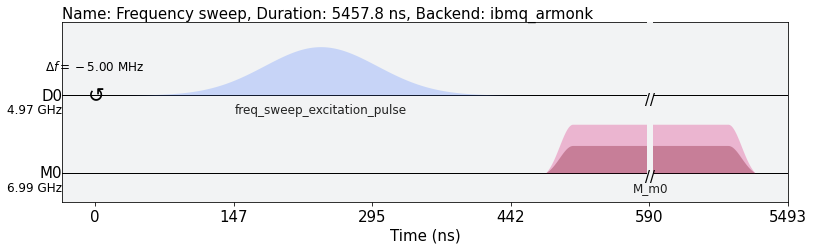

In [10]:
schedules[0].draw(backend=backend)
schedules[5].draw(backend=backend)

We request that each schedule (each point in our frequency sweep) is repeated `num_shots_per_frequency` times in order to get a good estimate of the qubit response.

We also specify measurement settings. `meas_level=0` returns raw data (an array of complex values per shot), `meas_level=1` returns kerneled data (one complex value per shot), and `meas_level=2` returns classified data (a 0 or 1 bit per shot). We choose `meas_level=1` to replicate what we would be working with if we were in the lab, and hadn't yet calibrated the discriminator to classify 0s and 1s. We ask for the `'avg'` of the results, rather than each shot individually.

You may see yet another unit change warning, we can safely ignore this. Finally, we can run the assembled program on the backend using:

In [11]:
num_shots_per_frequency = 1024

job = backend.run(schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)

In [12]:
print(job)

It is always a good idea to monitor the job status by using `job_monitor()`

In [13]:
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


Once the job is run, the results can be retrieved using:

In [14]:
frequency_sweep_results= job.result(timeout=120) # timeout parameter set to 120 second

We will extract the results and plot them using `matplotlib`:

(-1.25892672094208-1.211957361246208j)
(-1.233851225473024-1.228896443826176j)
(-0.961655525605376-1.467631395667968j)
(-0.960599836065792-1.453804553764864j)
(-1.232183033331712-1.222821078368256j)


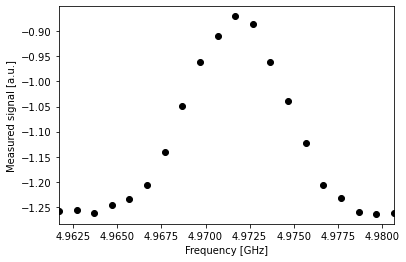

In [15]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])
    if (i%4==0): print((frequency_sweep_results.get_memory(i)*scale_factor)[0])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

As you can see above, the peak near the center corresponds to the location of the qubit frequency. The signal shows power-broadening, which is a signature that we are able to drive the qubit off-resonance as we get close to the center frequency. To get the value of the peak frequency, we will fit the values to a resonance response curve, which is typically a Lorentzian shape.

In [16]:
from scipy.optimize import curve_fit

def fit_function(x_values, y_values, function, init_params):
    fitparams, conv = curve_fit(function, x_values, y_values, init_params)
    y_fit = function(x_values, *fitparams)
    return fitparams, y_fit

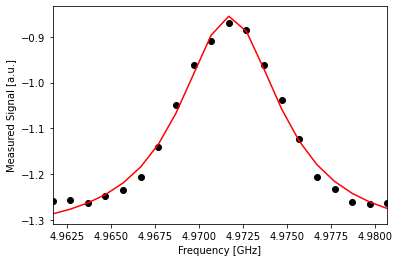

In [17]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: ((A/np.pi)*(B/ ((x-q_freq)**2+B**2))+C),
                                 [0.003, 4.9723, 0.003,-1.25] # initial parameters for curve_fit
                                )
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [18]:
A, rough_qubit_frequency, B, C = fit_params
rough_qubit_frequency = rough_qubit_frequency*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency/GHz, 5)} GHz.")
#print(fit_params)

We've updated our qubit frequency estimate from 4.97168 GHz to 4.97174 GHz.


# Using Rabi to Calibrate the $\pi$ Pulse for |0> -> |1>


In [19]:
# This experiment uses these values from the previous experiment:
    # `qubit`,
    # `mem_slot`, and
    # `rough_qubit_frequency`.

# Rabi experiment parameters
num_rabi_points = 50

# Drive amplitude values to iterate over: 50 amplitudes evenly spaced from 0 to 0.75
drive_amp_min = -1
drive_amp_max = 1
drive_amps = np.linspace(drive_amp_min, drive_amp_max, num_rabi_points)

In [20]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.

drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=drive_amp,
                              sigma=drive_sigma,
                              name='Rabi Pulse'), drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])

rabi_schedules = [rabi_sched.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

The schedule will look essentially the same as the frequency sweep experiment. The only difference is that we are running a set of experiments which vary the amplitude of the drive pulse, rather than its modulation frequency.

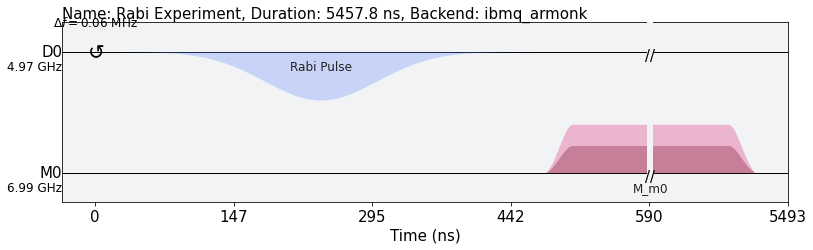

In [21]:
rabi_schedules[3].draw(backend=backend)

In [22]:
num_shots_per_point = 1024

job = backend.run(rabi_schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

job_monitor(job)

Job Status: job has successfully run


In [23]:
rabi_results = job.result(timeout=120)

Now that we have our results, we will extract them and fit them to a sinusoidal curve. For the range of drive amplitudes we selected, we expect that we will rotate the qubit several times completely around the Bloch sphere, starting from $|0\rangle$. The amplitude of this sinusoid tells us the fraction of the shots at that Rabi drive amplitude which yielded the $|1\rangle$ state.  We want to find the drive amplitude needed for the signal to oscillate from a maximum (all $|0\rangle$ state) to a minimum (all $|1\rangle$ state) -- this gives the calibrated amplitude that enacts a $\pi$ pulse.

In [24]:
# center data around 0
def baseline_remove(values):
    return np.array(values) - np.mean(values)

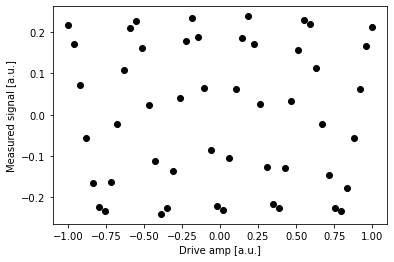

In [25]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

[ 0.22467697 -0.01074188  0.38619543  3.1538365 ]


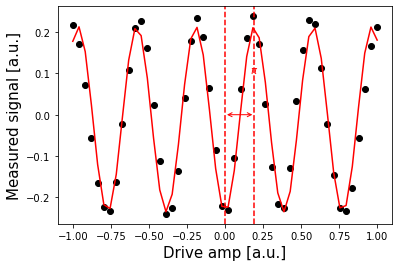

In [26]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [0.2, 0, 0.4, np.pi/2])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')
print(fit_params)
drive_period = fit_params[2] # get period of rabi oscillation

plt.axvline(0, color='red', linestyle='--')
plt.axvline(drive_period/2, color='red', linestyle='--')
plt.annotate("", xy=(0, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

In [27]:
pi_amp = abs(drive_period / 2)
print(f"Pi Amplitude = {pi_amp}")

Pi Amplitude = 0.19309771515336357


### Our $\pi$ pulse!
Let's define our pulse, with the amplitude we just found, so we can use it in later experiments.

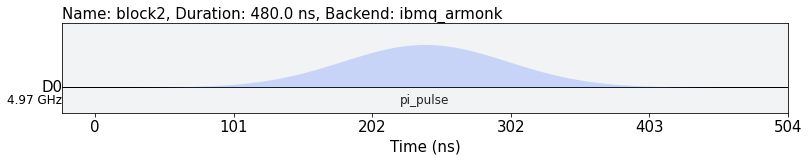

In [28]:
with pulse.build(backend) as pi_pulse_0_1:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp,
                              sigma=drive_sigma,
                              name='pi_pulse'), drive_chan)
pi_pulse_0_1.draw(backend=backend)

# Initial Freq 1->2

In [29]:
# We will sweep 40 MHz around the estimated frequency
frequency_span_Hz = 40 * MHz
# in steps of 1 MHz.
frequency_step_Hz = 1 * MHz
a=-0.35
# We will sweep 20 MHz above and 20 MHz below the estimated frequency
frequency_min = (center_frequency_Hz - frequency_span_Hz / 2)+a*GHz
frequency_max = (center_frequency_Hz + frequency_span_Hz / 2)+a*GHz
# Construct an np array of the frequencies for our experiment
frequencies_GHz = np.arange((frequency_min / GHz), 
                            (frequency_max / GHz), 
                            frequency_step_Hz / GHz)

print(f"The sweep will go from {frequency_min / GHz} GHz to {frequency_max / GHz} GHz \
in steps of {frequency_step_Hz / MHz} MHz.")
print(len(frequencies_GHz))

The sweep will go from 4.601680543795522 GHz to 4.641680543795522 GHz in steps of 1.0 MHz.
41


In [30]:
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.

# Drive pulse parameters (us = microseconds)
drive_sigma_sec = 0.015 * us                      # This determines the actual width of the gaussian
drive_duration_sec = drive_sigma_sec * 8                # This is a truncating parameter, because gaussians don't have 
                                                        # a natural finite length
drive_amp = 0.7

frequencies_Hz = frequencies_GHz*GHz
# Create the base schedule
# Start with drive pulse acting on the drive channel
freq = Parameter('freq')
with pulse.build(backend=backend, default_alignment='sequential', name='Frequency sweep') as sweep_sched:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse_0_1)
    pulse.set_frequency(freq, drive_chan)
    # Drive pulse samples
    #pulse.play(pulse.library.Constant(drive_duration, drive_amp), drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,sigma=drive_sigma,amp=drive_amp,name='freq_sweep_excitation_pulse'), drive_chan)
    # Define our measurement pulse
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])
        

# Create the frequency settings for the sweep (MUST BE IN HZ)
schedules = [sweep_sched.assign_parameters({freq: f}, inplace=False) for f in frequencies_Hz]

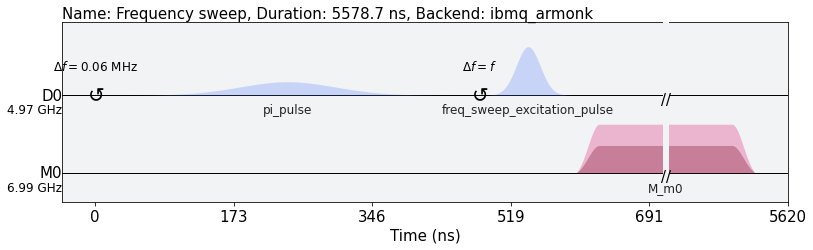

In [52]:
schedules[0].draw(backend=backend)
sweep_sched.draw(backend=backend)

In [32]:
num_shots_per_frequency = 1024
job = backend.run(schedules, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_frequency)
job_monitor(job)

Job Status: job has successfully run


In [33]:
frequency_sweep_results= job.result(timeout=120) # timeout parameter set to 120 second

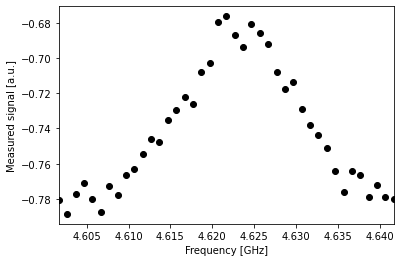

In [34]:
import matplotlib.pyplot as plt

sweep_values = []
for i in range(len(frequency_sweep_results.results)):
    # Get the results from the ith experiment
    res = frequency_sweep_results.get_memory(i)*scale_factor
    # Get the results for `qubit` from this experiment
    sweep_values.append(res[qubit])
    #if (i%4==0): print((frequency_sweep_results.get_memory(i)*scale_factor)[0])

plt.scatter(frequencies_GHz, np.real(sweep_values), color='black') # plot real part of sweep values
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])
plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured signal [a.u.]")
plt.show()

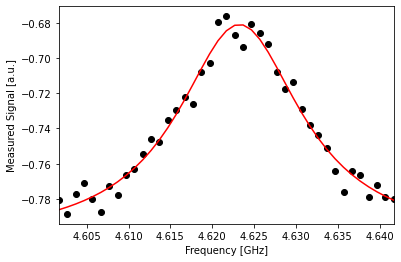

In [35]:
fit_params, y_fit = fit_function(frequencies_GHz,
                                 np.real(sweep_values), 
                                 lambda x, A, q_freq, B, C: ((A/np.pi)*(B/ ((x-q_freq)**2+B**2))+C),
                                 [0.003, 4.62, 0.003,-1.2] # initial parameters for curve_fit
                                )
plt.scatter(frequencies_GHz, np.real(sweep_values), color='black')
plt.plot(frequencies_GHz, y_fit, color='red')
plt.xlim([min(frequencies_GHz), max(frequencies_GHz)])

plt.xlabel("Frequency [GHz]")
plt.ylabel("Measured Signal [a.u.]")
plt.show()

In [36]:
A, rough_qubit_frequency_2, B, C = fit_params
rough_qubit_frequency_2 = rough_qubit_frequency_2*GHz # make sure qubit freq is in Hz
print(f"We've updated our qubit frequency estimate from "
      f"{round(backend_defaults.qubit_freq_est[qubit] / GHz, 5)} GHz to {round(rough_qubit_frequency_2/GHz, 5)} GHz.")
#print(fit_params)

We've updated our qubit frequency estimate from 4.97168 GHz to 4.62324 GHz.


# Using Rabi to Calibrate the $\pi$ Pulse for |1> -> |2> <a id="calib"></a>


In [37]:
# Build the Rabi experiments:
#    A drive pulse at the qubit frequency, followed by a measurement,
#    where we vary the drive amplitude each time.

drive_amp = Parameter('drive_amp')
with pulse.build(backend=backend, default_alignment='sequential', name='Rabi Experiment') as rabi_sched_2:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec*2))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec*2)
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse_0_1)
    pulse.set_frequency(rough_qubit_frequency_2, drive_chan)
    pulse.play(pulse.Gaussian(duration=drive_duration,amp=drive_amp,sigma=drive_sigma,name='Rabi Pulse'), drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])

rabi_schedules_2 = [rabi_sched_2.assign_parameters({drive_amp: a}, inplace=False) for a in drive_amps]

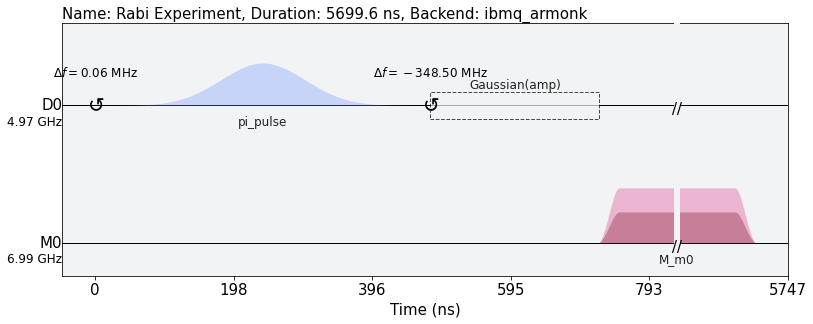

In [38]:
rabi_schedules_2[2].draw(backend=backend)
rabi_sched_2.draw(backend=backend)

In [39]:
num_shots_per_point = 2000

job = backend.run(rabi_schedules_2, 
                  meas_level=1, 
                  meas_return='avg', 
                  shots=num_shots_per_point)

job_monitor(job)

Job Status: job has successfully run


In [40]:
rabi_results = job.result(timeout=120)

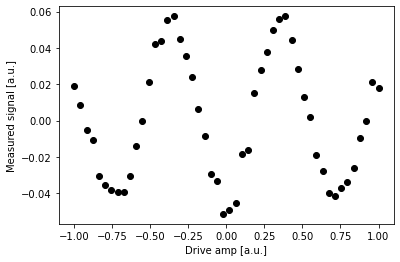

In [41]:
rabi_values = []
for i in range(num_rabi_points):
    # Get the results for `qubit` from the ith experiment
    rabi_values.append(rabi_results.get_memory(i)[qubit] * scale_factor)

rabi_values = np.real(baseline_remove(rabi_values))

plt.xlabel("Drive amp [a.u.]")
plt.ylabel("Measured signal [a.u.]")
plt.scatter(drive_amps, rabi_values, color='black') # plot real part of Rabi values
plt.show()

[0.04806702 0.00375785 0.73842967 3.10003536]


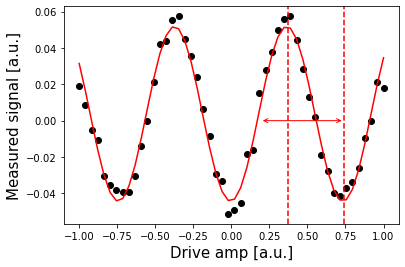

Pi Amplitude = 0.3692148371978982


In [42]:
fit_params, y_fit = fit_function(drive_amps,
                                 rabi_values, 
                                 lambda x, A, B, drive_period, phi: (A*np.cos(2*np.pi*x/drive_period - phi) + B),
                                 [0.2, -0.2, 0.75, np.pi/2])

plt.scatter(drive_amps, rabi_values, color='black')
plt.plot(drive_amps, y_fit, color='red')
print(fit_params)
drive_period_2 = fit_params[2] # get period of rabi oscillation

plt.axvline(drive_period_2/2, color='red', linestyle='--')
plt.axvline(drive_period_2, color='red', linestyle='--')
plt.annotate("", xy=(drive_period_2, 0), xytext=(drive_period/2,0), arrowprops=dict(arrowstyle="<->", color='red'))
plt.annotate("$\pi$", xy=(drive_period_2/2-0.03, 0.1), color='red')

plt.xlabel("Drive amp [a.u.]", fontsize=15)
plt.ylabel("Measured signal [a.u.]", fontsize=15)
plt.show()

pi_amp_2 = abs(drive_period_2 / 2)
print(f"Pi Amplitude = {pi_amp_2}")

### Our |1> -> |2> $\pi$ pulse!
Let's define our pulse, with the amplitude we just found, so we can use it in later experiments.

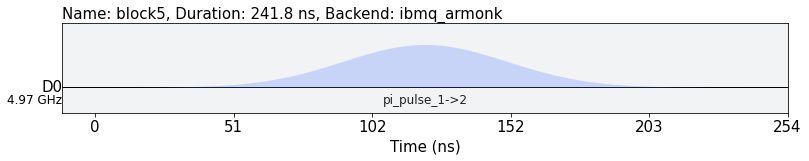

In [43]:
with pulse.build(backend) as pi_pulse_0_2:
    drive_duration = get_closest_multiple_of_16(pulse.seconds_to_samples(drive_duration_sec*2))
    drive_sigma = pulse.seconds_to_samples(drive_sigma_sec*2)
    drive_chan = pulse.drive_channel(qubit)
    pulse.play(pulse.Gaussian(duration=drive_duration,
                              amp=pi_amp_2,
                              sigma=drive_sigma,
                              name='pi_pulse_1->2'), drive_chan)
pi_pulse_0_2.draw(backend=backend)

# Determining 0 vs 1 vs 2 <a id="zerovone"></a>

Once our $\pi$ pulses have been calibrated, we can now create the state $\vert1\rangle$ with good probability. We can use this to find out what the states $\vert0\rangle$ and $\vert1\rangle$ look like in our measurements, by repeatedly preparing them and plotting the measured signal. This is what we use to build a discriminator, which is simply a function which takes a measured and kerneled complex value (`meas_level=1`) and classifies it as a 0 or a 1 (`meas_level=2`).

In [44]:
# Create two schedules

# Ground state schedule
with pulse.build(backend=backend, default_alignment='sequential', name='ground state') as gnd_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])


# Excited state schedule
with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_1_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse_0_1)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])
    
with pulse.build(backend=backend, default_alignment='sequential', name='excited state') as exc_2_schedule:
    drive_chan = pulse.drive_channel(qubit)
    pulse.set_frequency(rough_qubit_frequency, drive_chan)
    pulse.call(pi_pulse_0_1)
    pulse.set_frequency(rough_qubit_frequency_2, drive_chan)
    pulse.call(pi_pulse_0_2)
    pulse.measure(qubits=[qubit], registers=[pulse.MemorySlot(mem_slot)])

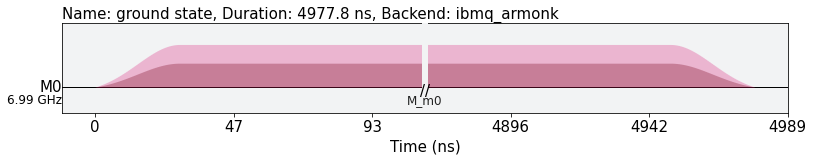

In [45]:
gnd_schedule.draw(backend=backend)

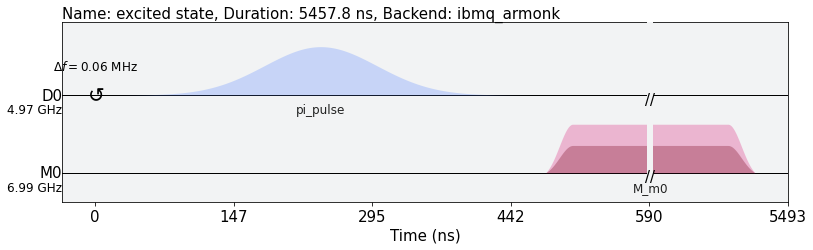

In [46]:
exc_1_schedule.draw(backend=backend)

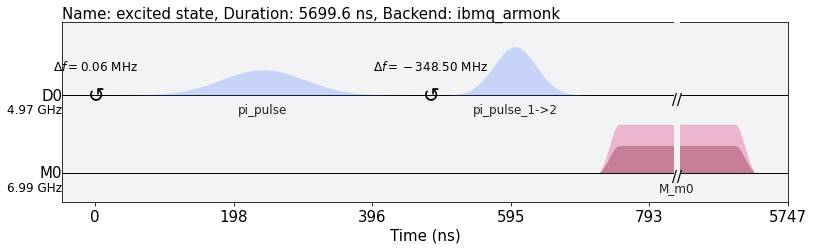

In [47]:
exc_2_schedule.draw(backend=backend)

We assemble the ground and excited state preparation schedules. Each of these will run `num_shots` times. We choose `meas_level=1` this time, because we do not want the results already classified for us as $|0\rangle$ or $|1\rangle$. Instead, we want kerneled data: raw acquired data that has gone through a kernel function to yield a single complex value for each shot. (You can think of a kernel as a dot product applied to the raw measurement data.)

In [48]:
# Execution settings
num_shots = 1024

job = backend.run([gnd_schedule, exc_1_schedule, exc_2_schedule], 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [49]:
gnd_exc_results = job.result(timeout=120)

Now that we have the results, we can visualize the two populations which we have prepared on a simple scatter plot, showing results from the ground state program in blue and results from the excited state preparation program in red. Note: If the populations irregularly shaped (not approximately circular), try re-running the notebook.

## |0> and |1> Discrimination

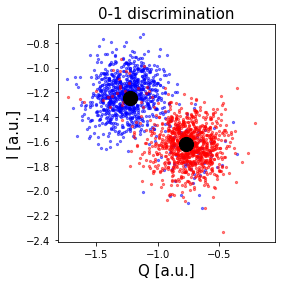

In [50]:
gnd_results = gnd_exc_results.get_memory(0)[:, qubit]*scale_factor
exc_1_results = gnd_exc_results.get_memory(1)[:, qubit]*scale_factor
plt.figure()

# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc_1_results), np.imag(exc_1_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')

plt.axis('square')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_1_exc = np.mean(exc_1_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_1_exc), np.imag(mean_1_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1 discrimination", fontsize=15)

plt.show()

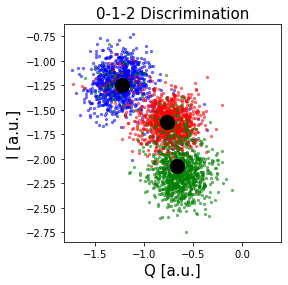

In [51]:
exc_2_results = gnd_exc_results.get_memory(2)[:, qubit]*scale_factor
plt.figure()

# Plot all the results
# All results from the gnd_schedule are plotted in blue
plt.scatter(np.real(gnd_results), np.imag(gnd_results), 
                s=5, cmap='viridis', c='blue', alpha=0.5, label='state_0')
# All results from the exc_schedule are plotted in red
plt.scatter(np.real(exc_1_results), np.imag(exc_1_results), 
                s=5, cmap='viridis', c='red', alpha=0.5, label='state_1')
plt.scatter(np.real(exc_2_results), np.imag(exc_2_results), 
                s=5, cmap='viridis', c='green', alpha=0.5, label='state_2')
plt.axis('square')

# Plot a large dot for the average result of the 0 and 1 states.
mean_gnd = np.mean(gnd_results) # takes mean of both real and imaginary parts
mean_1_exc = np.mean(exc_1_results)
mean_2_exc = np.mean(exc_2_results)
plt.scatter(np.real(mean_gnd), np.imag(mean_gnd), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_0_mean')
plt.scatter(np.real(mean_1_exc), np.imag(mean_1_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')
plt.scatter(np.real(mean_2_exc), np.imag(mean_2_exc), 
            s=200, cmap='viridis', c='black',alpha=1.0, label='state_1_mean')

plt.ylabel('I [a.u.]', fontsize=15)
plt.xlabel('Q [a.u.]', fontsize=15)
plt.title("0-1-2 Discrimination", fontsize=15)

plt.show()